In [10]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


In [11]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [12]:
def pretty_print_best_params(best_params: dict, best_score: float) -> None:
    print(f"Best Score: {best_score:.4f}")
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")


def print_accuracy(y_pred, y_test) -> None:
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

In [13]:
def func(trial, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray) -> float:
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    p = trial.suggest_int('p', 1, 4)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric, p=p
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [14]:
def get_best_hyperparameters(
        X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray
) -> tuple[dict, float]:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        func=lambda trial: func(trial, X_train, X_val, y_train, y_val),
        n_trials=100,
        show_progress_bar=True
    )
    best_params = study.best_params
    best_value = study.best_value
    return best_params, best_value


In [15]:
def get_split_data():
    data = load_iris()
    X, y = data.data, data.target
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_test, X_train, X_val, y_test, y_train, y_val

In [16]:
X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
best_params, best_score = get_best_hyperparameters(X_train, X_val, y_train, y_val)
print("~" * 40)
pretty_print_best_params(best_params, best_score)

[I 2024-09-11 21:00:46,084] A new study created in memory with name: no-name-636a5076-5780-4715-9d7b-9399d5b74236


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-09-11 21:00:46,091] Trial 0 finished with value: 0.7083333333333334 and parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 0 with value: 0.7083333333333334.
[I 2024-09-11 21:00:46,094] Trial 1 finished with value: 0.9166666666666666 and parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-09-11 21:00:46,097] Trial 2 finished with value: 0.9166666666666666 and parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-09-11 21:00:46,099] Trial 3 finished with value: 0.9166666666666666 and parameters: {'n_neighbors': 12, 'p': 2, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9166666666666666.
[I 2024-09-11 21:00:46,103] Trial 4 finished with value: 0.9166666666666666 and parameters: {'n_neighbors': 13, 'p': 4, 'weights': 'uniform', 'met

In [17]:
def plot_accuracy_vs_k(X_test, X_train, y_test, y_train, weights, metric, p):
    ks = range(1, 30)
    train_accuracies = []
    test_accuracies = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric, p=p)
        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_test_pred = knn.predict(X_test)
        test_accuracies.append(accuracy_score(y_test, y_test_pred))

    plt.plot(ks, train_accuracies, label='Train Accuracy')
    plt.plot(ks, test_accuracies, label='Test Accuracy')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Neighbors')
    plt.legend()
    plt.show()

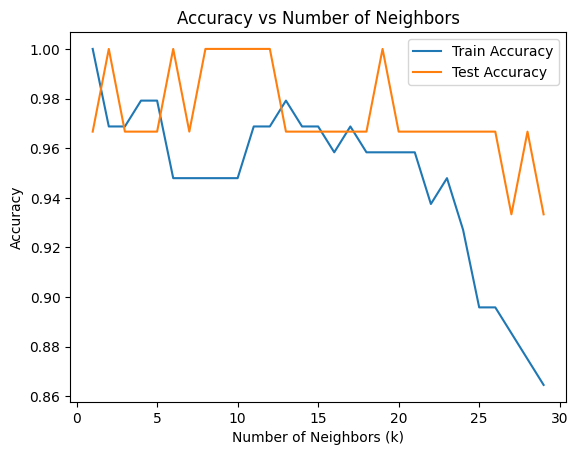

In [18]:
plot_accuracy_vs_k(X_test, X_train, y_test, y_train,
                   weights=best_params['weights'],
                   metric=best_params['metric'],
                   p=best_params['p'])